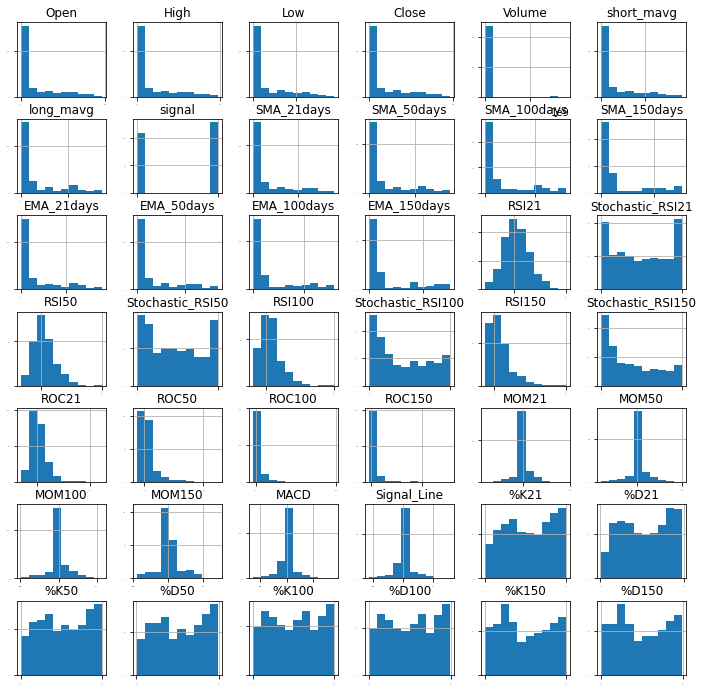

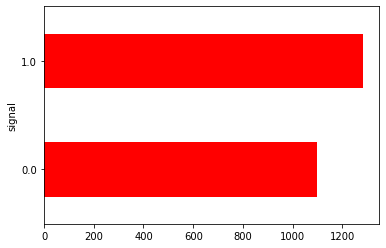

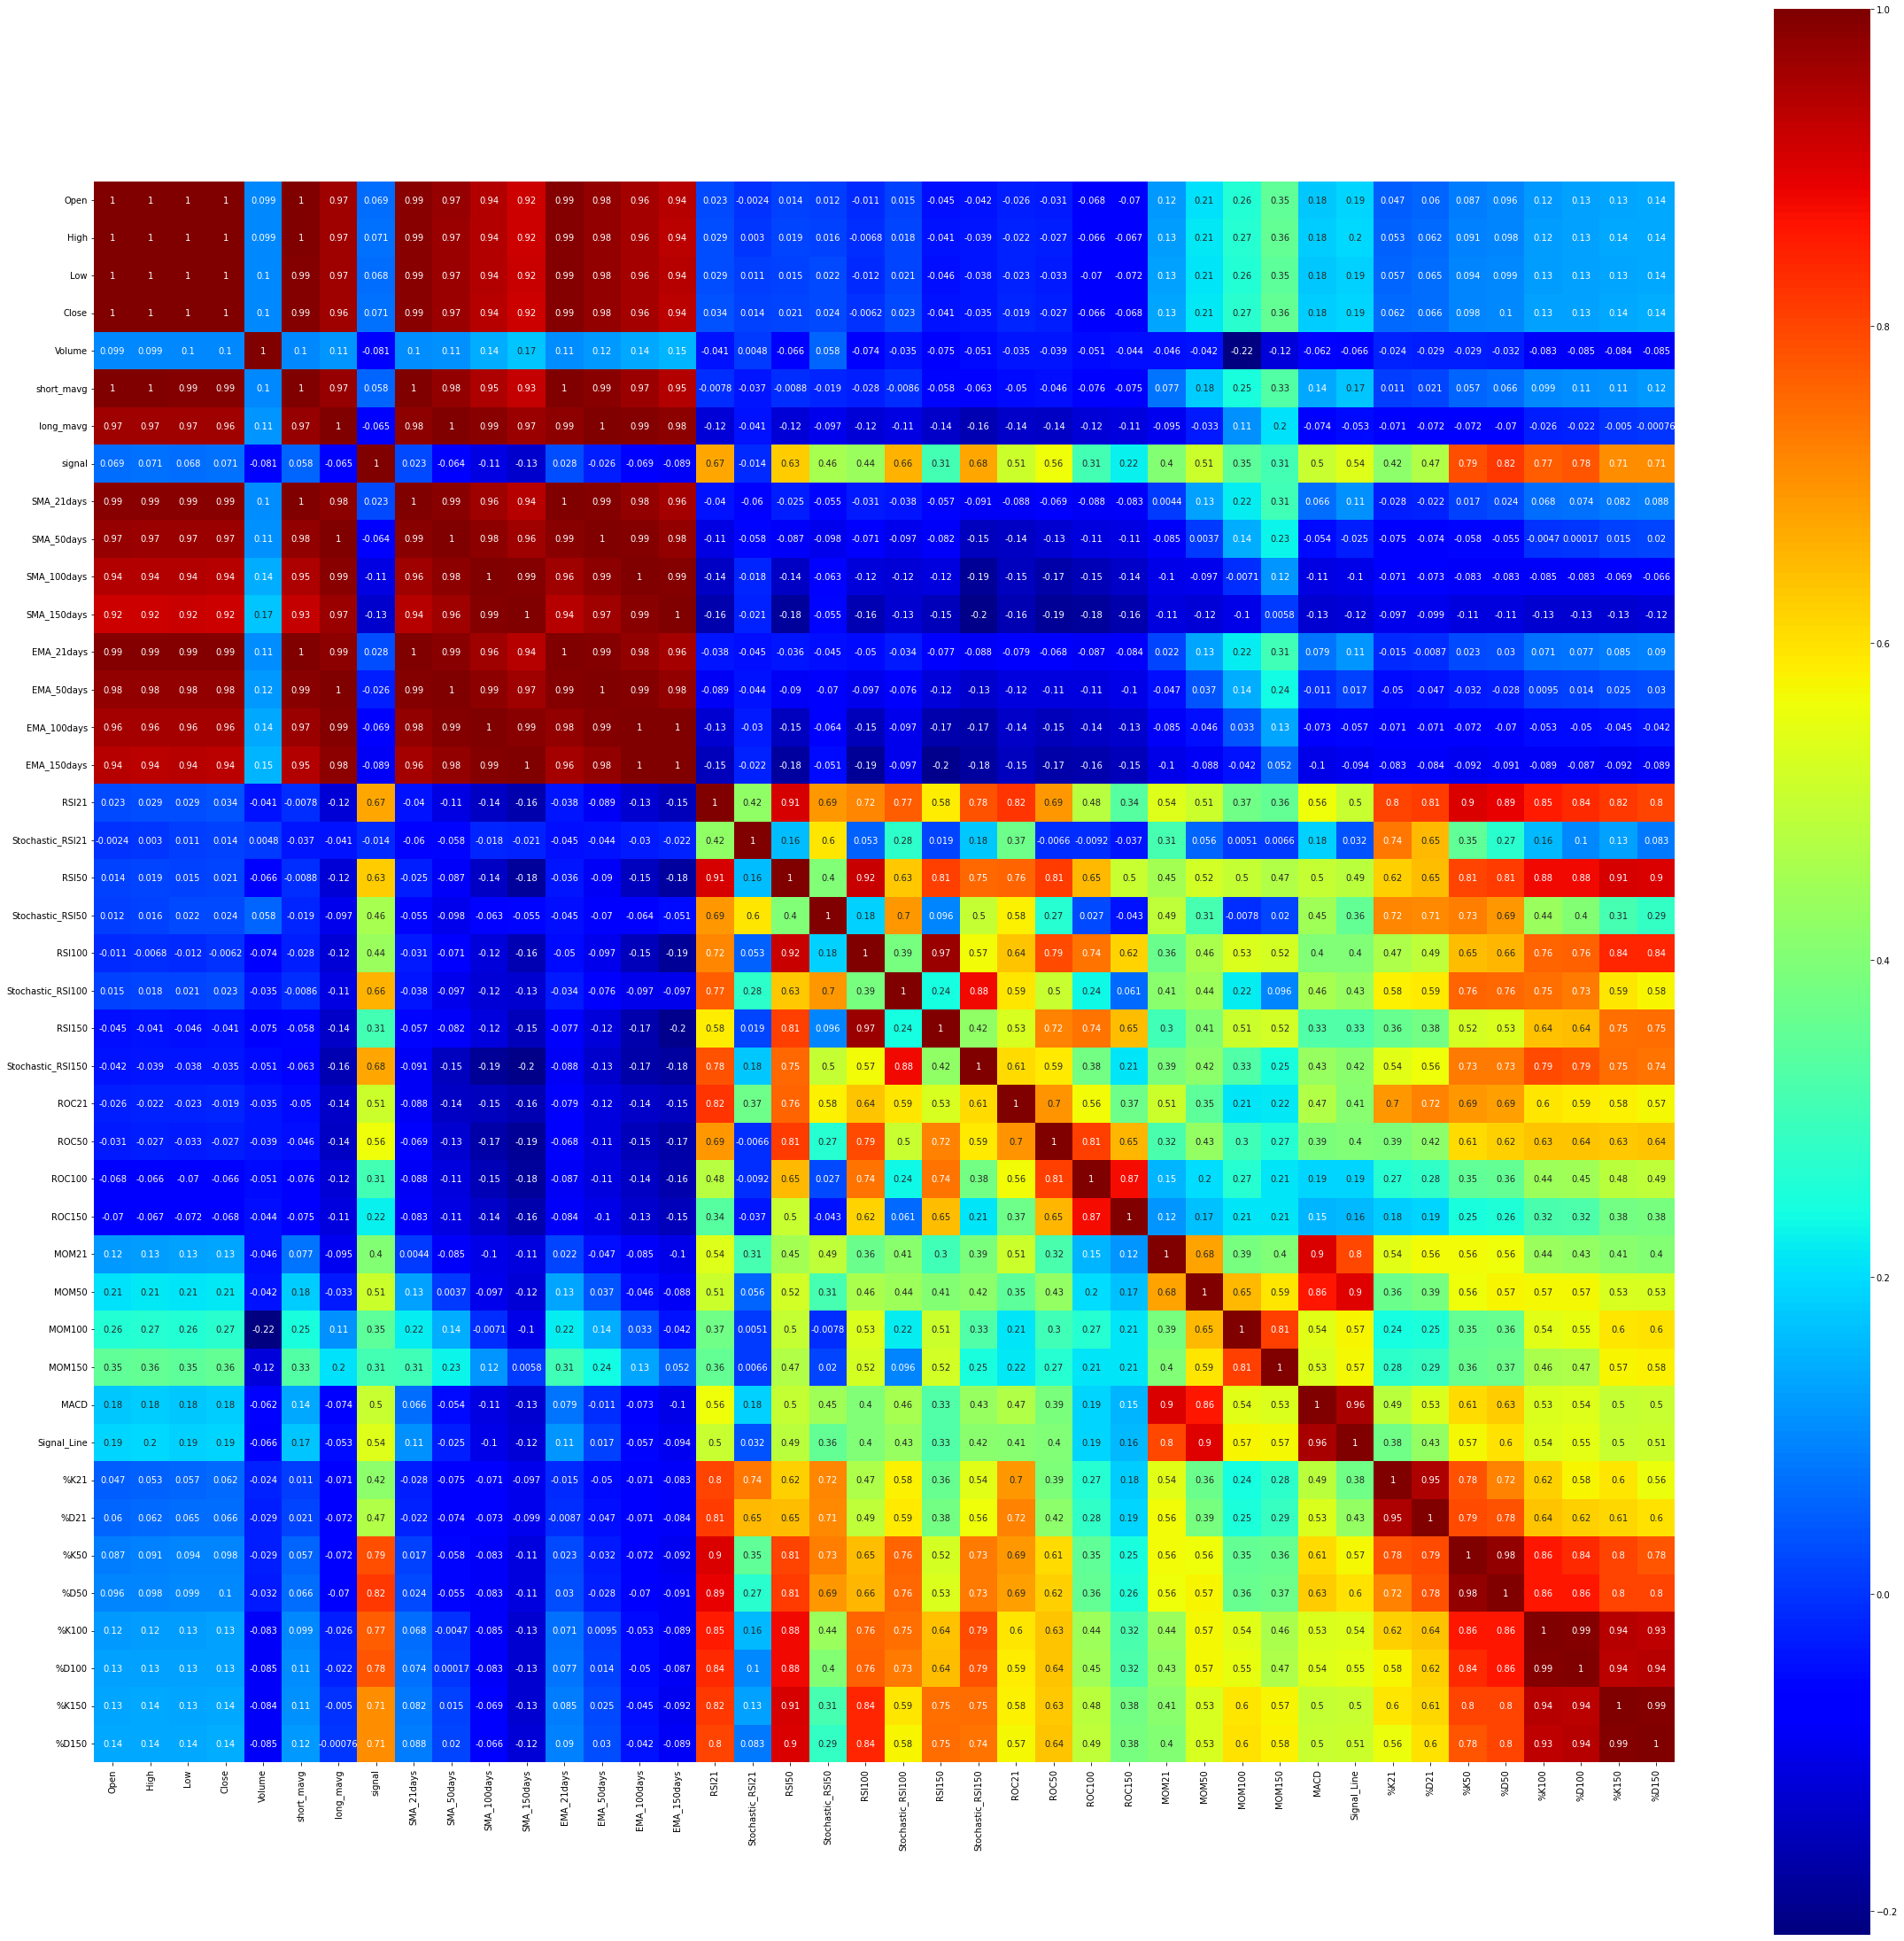

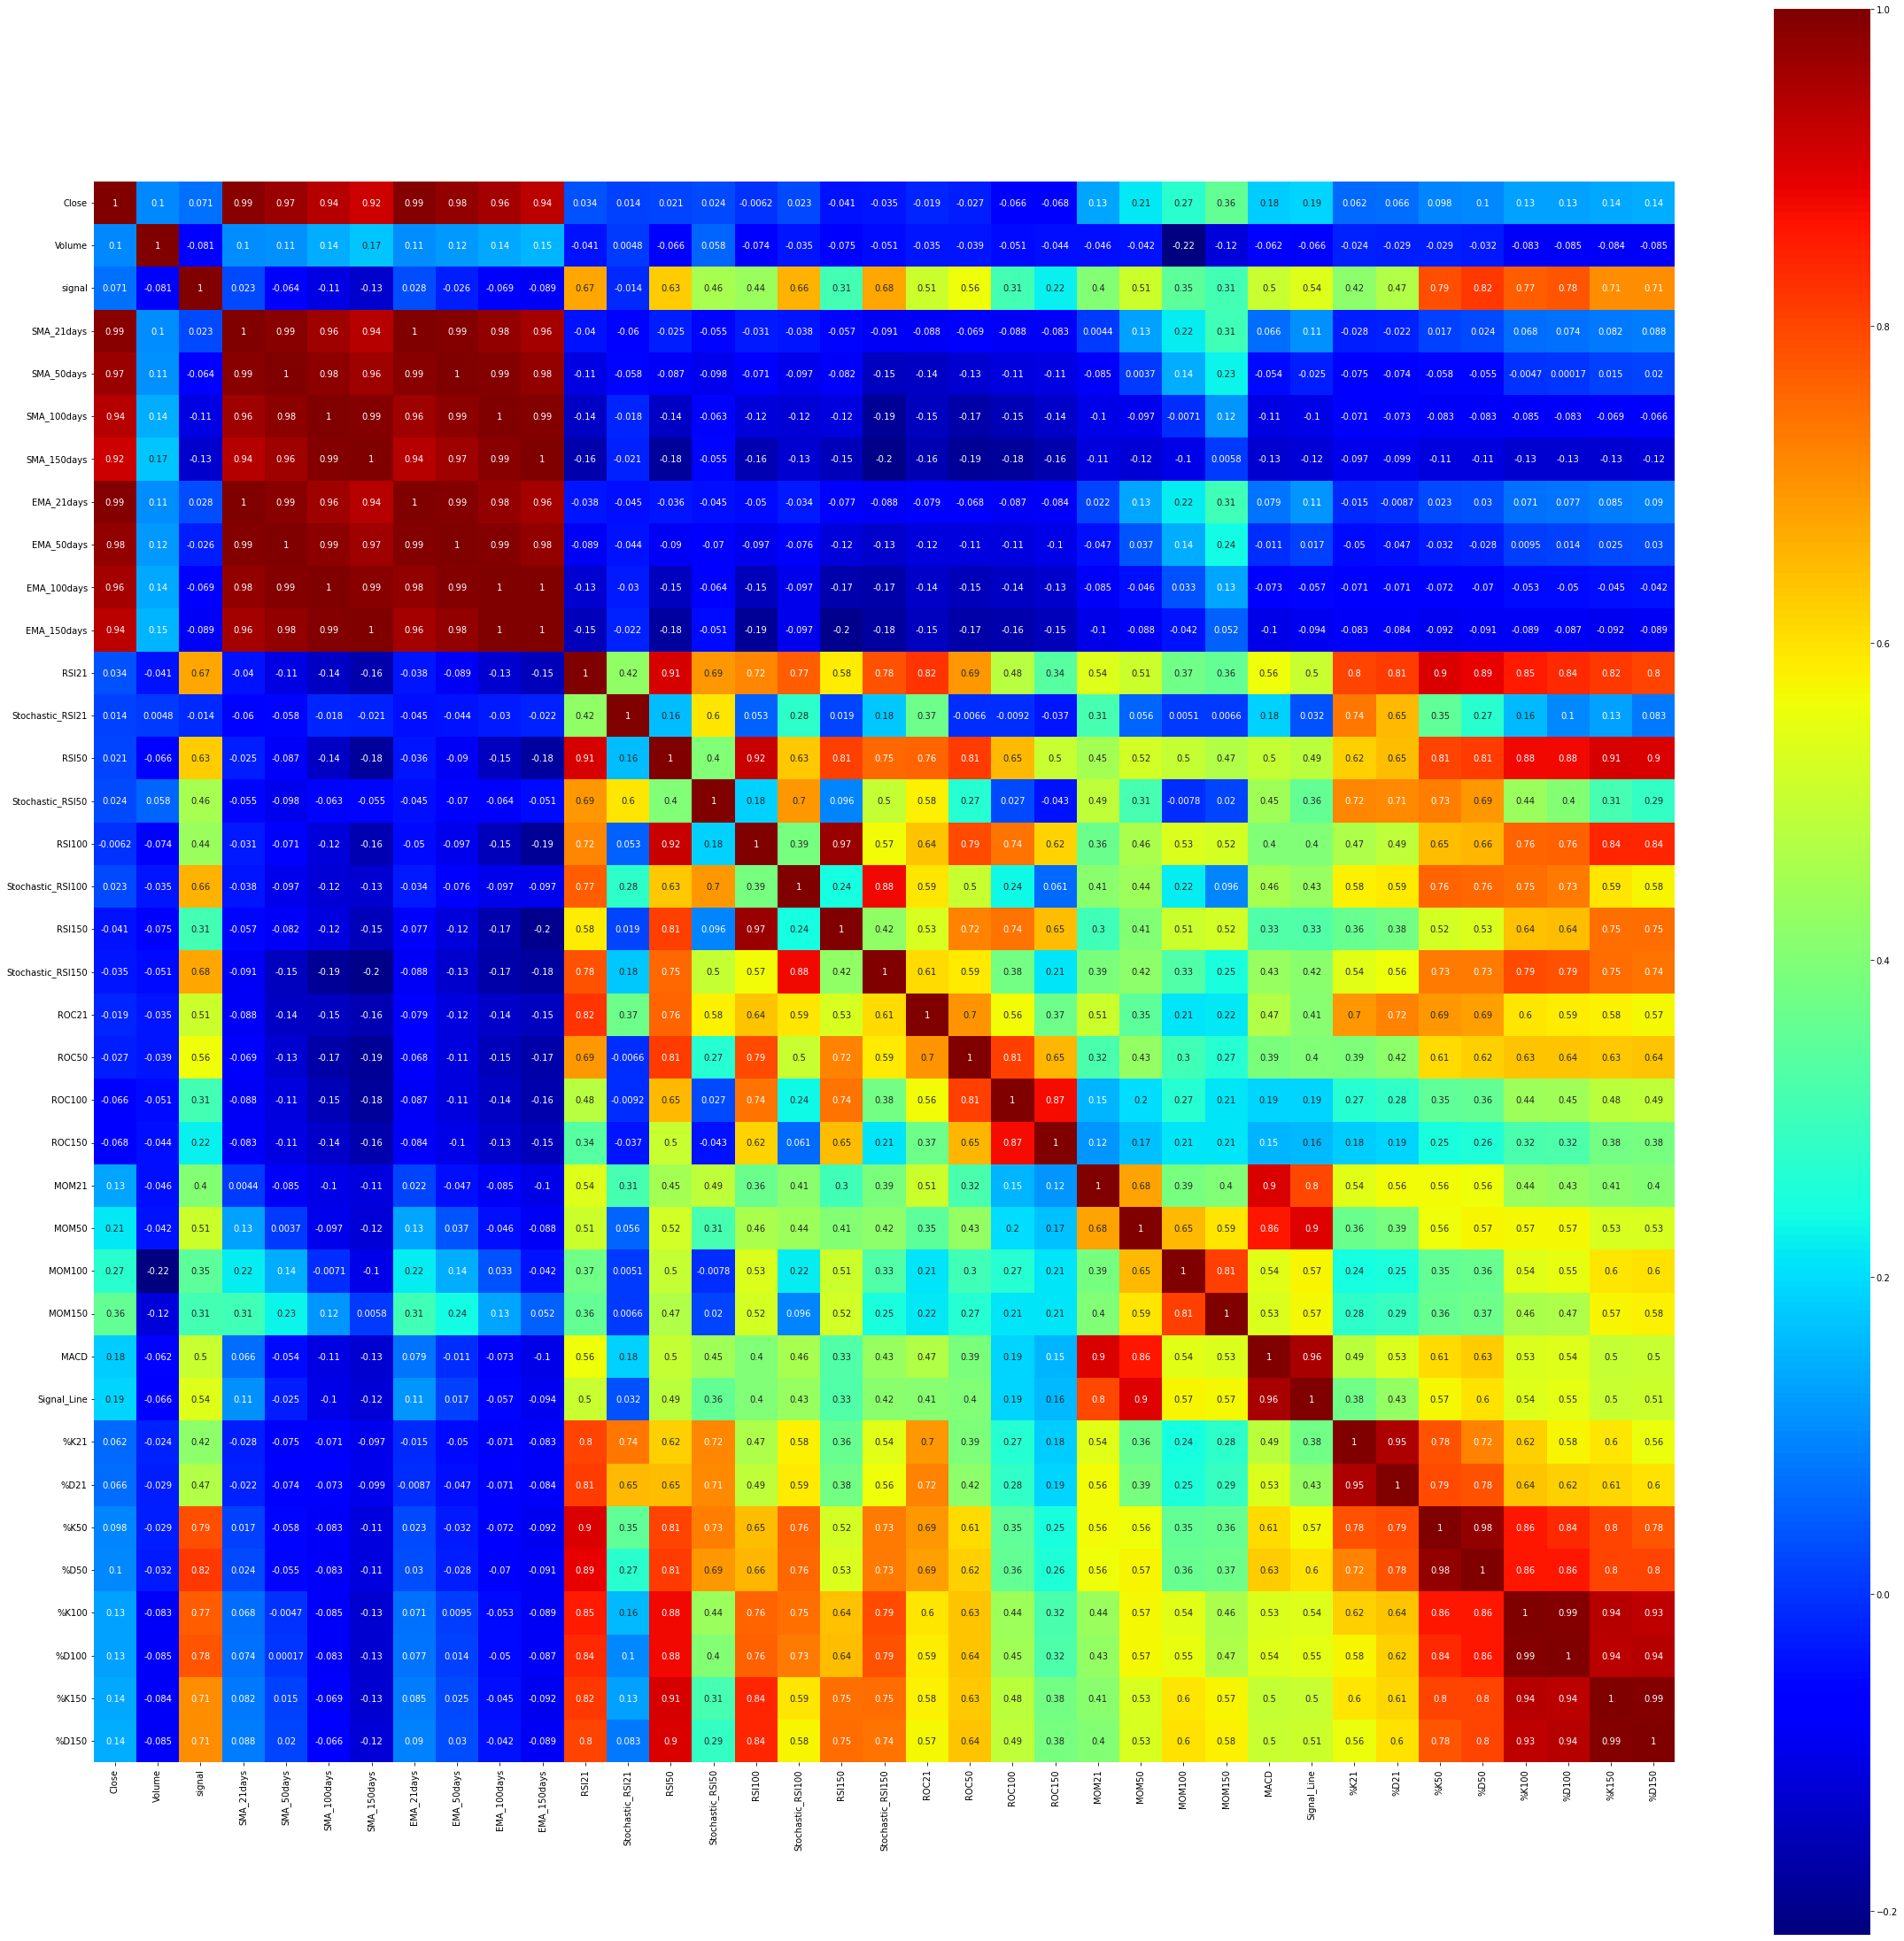

LR: 0.545238 (0.161218)
KNN: 0.529789 (0.043697)
CART: 0.974091 (0.010828)
LDA: 0.952369 (0.015206)
NN: 0.596287 (0.058933)
AB: 0.975495 (0.010467)
GBM: 0.975495 (0.011779)
RF: 0.978287 (0.009597)
ETC: 0.975495 (0.009988)
SVC: 0.538225 (0.038148)
NB: 0.537541 (0.037241)
Saving figure ETH prediction - Models Evaluation


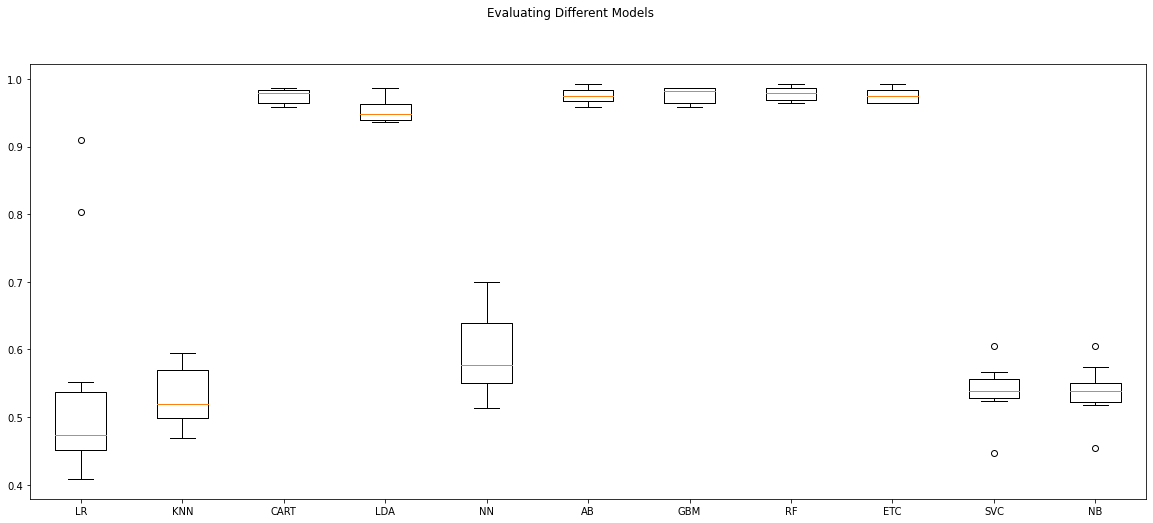

Best: 0.979691 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#4 0.978292 (0.011875) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#7 0.975490 (0.013341) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#1 0.979691 (0.012283) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#5 0.977593 (0.010260) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#2 0.979681 (0.008531) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#8 0.974791 (0.015366) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#6 0.976889 (0.014344) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.978991 (0.009876) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
0.9831932773109243
[[158   1]
 [  5 193]]
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       159
         1.0       0.99      0.97      0.98       198

    accura

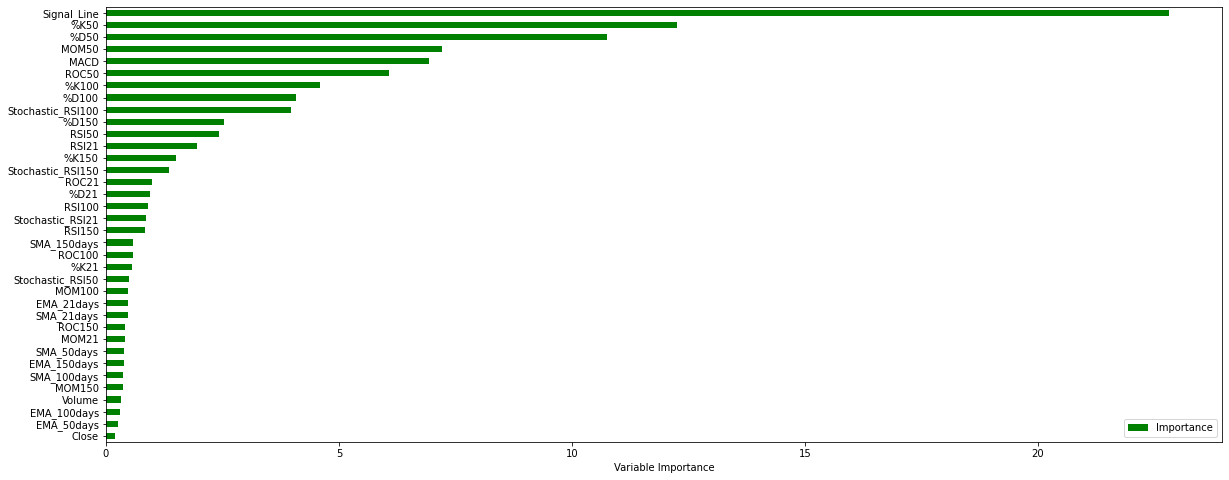

Saving figure Backtest - strat return vs actual return histogram


<Figure size 432x288 with 0 Axes>

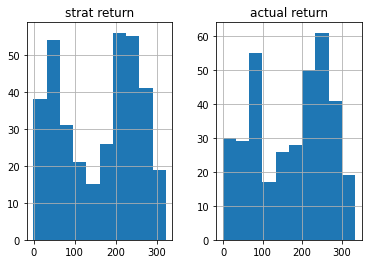

Saving figure Backtest - strat return vs actual return


<Figure size 432x288 with 0 Axes>

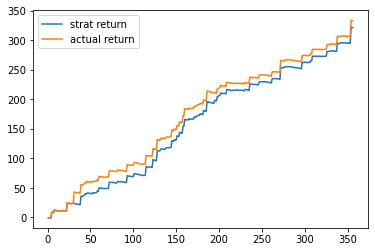

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [117]:
%run ETH_predictor.ipynb

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from ipywidgets import interactive, fixed

### Load the data

In [2]:
df = pd.read_csv('../data/ETH-USD.csv')

In [19]:
def signals(df):
    df['short_mavg'] = df['Close'].rolling(window=10, min_periods=1, center=False).mean()
    df['long_mavg'] = df['Close'].rolling(window=60, min_periods=1, center=False).mean()
    df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

def SMA(df): #Short Moving Average
    df['SMA_21days'] = df.iloc[:,3].rolling(window=21).mean()
    df['SMA_50days'] = df.iloc[:,3].rolling(window=50).mean()
    df['SMA_100days'] = df.iloc[:,3].rolling(window=100).mean()
    df['SMA_150days'] = df.iloc[:,3].rolling(window=150).mean()

def EMA(df): #Exponential Moving Average
    df['EMA_21days'] = df['Close'].ewm(span=21,adjust=False).mean()
    df['EMA_50days'] = df['Close'].ewm(span=50,adjust=False).mean()
    df['EMA_100days'] = df['Close'].ewm(span=100,adjust=False).mean()
    df['EMA_150days'] = df['Close'].ewm(span=150,adjust=False).mean()

def RSIs(df,n): #Relative Strength Index
    df['diff'] = df.Close.diff()
    df['pos'] = df['diff'].clip(lower=0)
    df['neg'] = -1*df['diff'].clip(upper=0)
    ema_pos = df['pos'].ewm(com=(n-1), adjust=False).mean()
    ema_neg = df['neg'].ewm(com=(n-1), adjust=False).mean()
    relative_str = ema_pos / ema_neg
    df['RSI'+str(n)] = 100-(100/(1+relative_str))
    df['Stochastic_RSI'+str(n)] = (df['RSI'+str(n)]-df['RSI'+str(n)].rolling(n).min())/(df['RSI'+str(n)].rolling(n).max()-(df['RSI'+str(n)].rolling(n).min()))

def ROC(df, n): #Rate of Change
    M = df.diff(n-1)
    N = df.shift(n-1)
    ROC = pd.Series(((M/N)*100),name='Roc_'+str(n))
    return ROC

def MOM(df,n): #Momentum
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM

def MACD(df): # Moving Average Convergence Divergence... default is 12-26-9
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1-exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

def Stochastic(df,n): #Stochastic Oscillator
    high = df['High'].rolling(n).max()
    low = df['Low'].rolling(n).min()
    df['%K'+str(n)] = (df['Close']-low)*100/(high-low) #current price in relation to the asset's recent price change...
    df['%D'+str(n)] = df['%K'+str(n)].rolling(3).mean() #3 period average of %K

signals(df)
SMA(df)
RSIs(df, 21)
RSIs(df, 50)
RSIs(df, 100)
RSIs(df, 150)
df['ROC21'] = ROC(df['Close'],21)
df['ROC50'] = ROC(df['Close'],50)
df['ROC100'] = ROC(df['Close'],100)
df['ROC150'] = ROC(df['Close'],150)
df['MOM21'] = MOM(df['Close'], 21)
df['MOM50'] = MOM(df['Close'], 50)
df['MOM100'] = MOM(df['Close'], 100)
df['MOM150'] = MOM(df['Close'], 150)
MACD(df)
Stochastic(df,21)
Stochastic(df,50)
Stochastic(df,100)
Stochastic(df,150)

In [24]:
df = df.drop(['Open','Date','High','Low', 'short_mavg','long_mavg'],axis=1)

In [20]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [21]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Train Test Split

In [25]:
val_size = 0.2
seed = 42
val = int(df.shape[0]*0.8)
subset = df.iloc[-val:]
X = subset.loc[:, df.columns != 'signal']
y = subset['signal']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=val_size, random_state=seed)

### Standardization

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
rs_df = pd.DataFrame(X_scaled, columns = X_train.columns, index=X_train.index)

X_train.dropna(how='any', inplace=True)
rs_df.dropna(how='any', inplace=True)

In [78]:
rs_df

Close    Volume  Adj Close  SMA_21days  SMA_50days  SMA_100days  \
1494  1.060752 -0.334191   1.060752    1.168186    1.599138     2.026518   
388  -0.913932 -1.308688  -0.913932   -0.899353   -0.905444    -0.878073   
567  -0.836698 -0.945156  -0.836698   -0.797477   -0.788498    -0.808902   
1231  1.760921  2.960637   1.760921    1.579832    1.057442     0.723080   
1773 -0.156366  2.151784  -0.156366    0.145434    0.078670     0.200063   
...        ...       ...        ...         ...         ...          ...   
1452  2.162139  0.165858   2.162139    2.156266    2.340726     2.112248   
1487  0.863298 -0.013219   0.863298    1.323709    1.754524     2.106747   
1651 -0.103771 -0.502812  -0.103771   -0.114238    0.133619     0.676352   
1217  1.271104  1.120366   1.271104    0.881839    0.642418     0.471799   
1483  0.949659  0.020580   0.949659    1.509210    1.864796     2.149120   

      SMA_150days      diff       pos       neg  ...      MACD  Signal_Line  \
1494     1.964732 -0.060474 -0.450377 -0.317032  ... -2.038279    -2.689815   
388     -0.847506 -0.018848 -0.450377 -0.377577  ... -0.095014    -0.081634   
567     -0.823564 -0.111087 -0.450377 -0.243414  ... -0.241149    -0.203218   
1231     0.451398 -0.602790 -0.450377  0.471786  ...  3.584027     4.070593   
1773     0.156285 -2.706775 -0.450377  3.532106  ... -0.019984     0.405146   
...           ...       ...       ...       ...  ...       ...          ...   
1452     1.934584  1.437425  1.903512 -0.379086  ... -0.815978    -1.017979   
1487     2.005534 -0.538221 -0.450377  0.377868  ... -3.369166    -3.078931   
1651     0.892635 -0.579221 -0.450377  0.437505  ... -0.717103    -1.153751   
1217     0.223096  0.053419 -0.335159 -0.379086  ...  2.080335     1.692986   
1483     2.021118  1.482982  1.977202 -0.379086  ... -3.016105    -2.486589   

          %K21      %D21      %K50      %D50     %K100     %D100     %K150  \
1494 -0.420066 -0.350334 -0.943983 -0.893944 -1.159294 -1.117722 -1.063198   
388  -1.621741 -1.656115 -0.327463 -0.312495 -0.949247 -0.943888 -1.156993   
567  -1.186066 -1.069037 -1.326522 -1.217339 -0.733546 -0.632089 -0.384454   
1231  0.248532  0.593687  0.563057  0.800276  0.728505  0.932348  0.964598   
1773 -1.717810 -0.766392 -1.695692 -0.592400 -1.726477 -1.107021 -1.080724   
...        ...       ...       ...       ...       ...       ...       ...   
1452 -0.094320 -0.375317 -0.381661 -0.563982  0.389370  0.282468  0.690149   
1487 -1.149181 -1.220503 -1.433266 -1.419361 -1.476529 -1.452829 -1.376431   
1651  0.191803  0.757933 -1.031596 -0.951924 -1.444556 -1.409750 -1.344861   
1217  1.386435  1.474066  1.439905  1.486740  1.518770  1.549522  1.597757   
1483 -1.375895 -1.634742 -1.477491 -1.644501 -1.517744 -1.645336 -1.417126   

         %D150  
1494 -1.019095  
388  -1.153456  
567  -0.292952  
1231  1.127334  
1773 -0.392068  
...        ...  
1452  0.612163  
1487 -1.349343  
1651 -1.306888  
1217  1.619316  
1483 -1.539059  

[1139 rows x 36 columns]

### Dimensionality Reduction --- Singular Value Decomposition (SVD)

In [30]:
ncomps = 10
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(rs_df)

In [31]:
svd.components_[0]

array([ 0.0212392 ,  0.08961165,  0.0212392 , -0.00844551, -0.03563426,
       -0.05569527, -0.06712855,  0.04773174,  0.0460851 , -0.0279863 ,
        0.23356526,  0.07528501,  0.23862146,  0.14411721,  0.22036195,
        0.18193809,  0.13551632,  0.17539343,  0.19538473,  0.2149873 ,
        0.17806759,  0.16748041,  0.17933548,  0.19287169,  0.15825229,
        0.15390768,  0.19943273,  0.19062485,  0.18302342,  0.18886777,
        0.22610004,  0.22584958,  0.22679166,  0.22383611,  0.2218209 ,
        0.21867481])

Saving figure Explained Variance Ratio by Top 10 factors
Saving figure Cumulative Explained Variance by factor


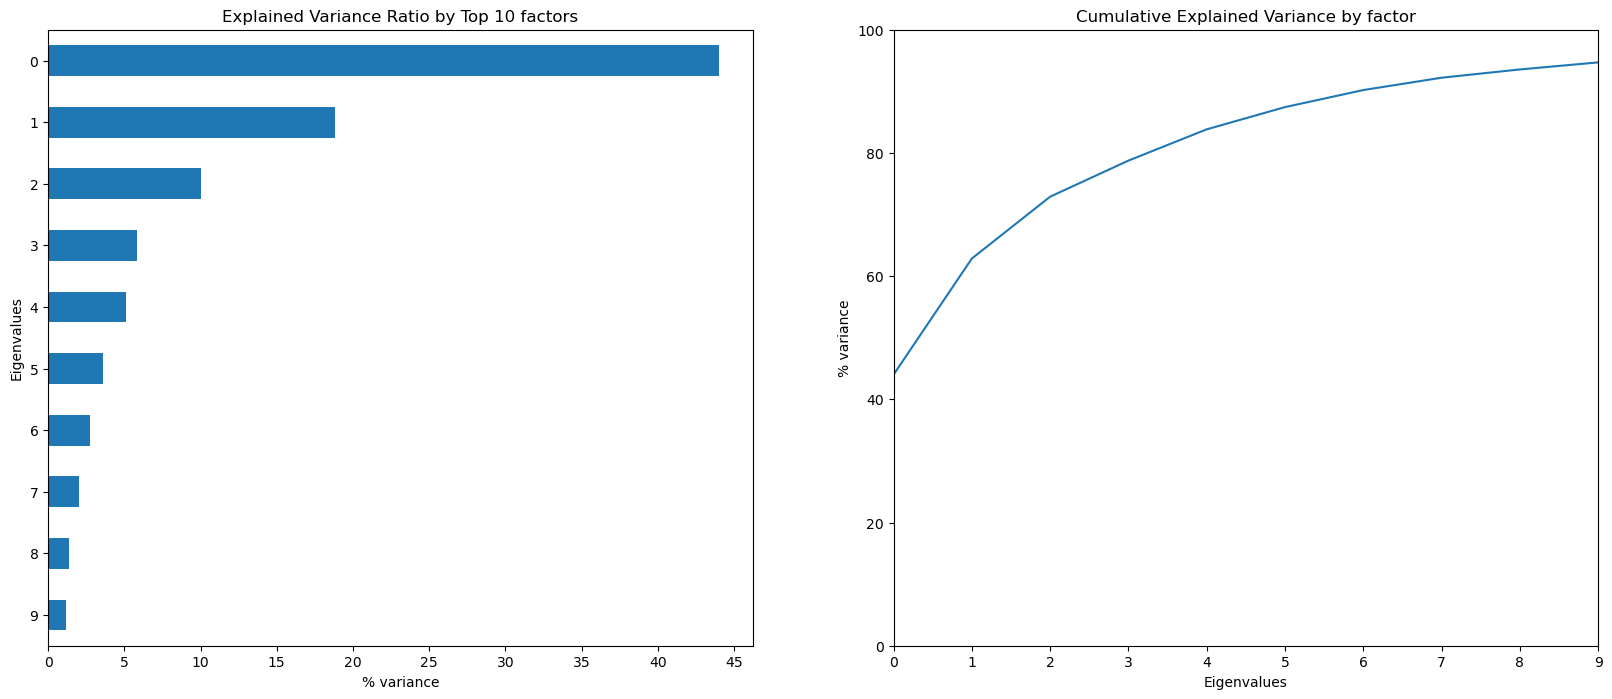

In [77]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
Series1 = pd.Series(svd.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0])
ax1 = Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0])
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('% variance')
ax1.set_ylabel('Eigenvalues')
save_fig('Explained Variance Ratio by Top 10 factors',tight_layout=False)
Series2 = pd.Series(svd.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
ax2 = Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlabel('Eigenvalues')
ax2.set_ylabel('% variance')
save_fig('Cumulative Explained Variance by factor',tight_layout=False)
# explained_variance
pd.Series(np.cumsum(svd.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

In [33]:
rs_df.shape

(1139, 36)

Can preserve 95% variance from 8 Eigenvalues compared to the 36 features

In [34]:
y_pred = svd.fit_transform(rs_df)

In [35]:
svd_df = pd.DataFrame(y_pred, columns=['c{}'.format(c) for c in range(ncomps)], index=rs_df.index)

In [36]:
svd_df.shape

(1139, 10)

In [37]:
svd_df.head(5)

c0        c1        c2        c3        c4        c5        c6  \
1494 -5.960659  2.592654 -2.063819  0.078344 -2.315781  1.386417 -0.710446   
388  -2.938059 -2.801208  1.388430 -0.582319  1.742273 -1.290102 -1.434701   
567  -2.986941 -1.999901  2.293204 -0.840515  0.801351 -0.220574 -0.382007   
1231  7.338497  4.539896  3.250268  0.543555  4.689242 -0.586054  0.855687   
1773 -4.622465  1.559019  2.350769  3.615530  1.475506  0.115463  2.753642   

            c7        c8        c9  
1494  0.338317 -1.228214 -0.307531  
388   1.512988 -0.016502  0.383830  
567  -0.394578 -0.140354  0.050085  
1231  0.020182 -1.542942 -0.759794  
1773  0.279053  1.301835 -0.167597

### Visualize the compressed dataset... from top 5 component of SVD

In [38]:
[c for c in svd_df.columns if c[0] == 'c']

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [39]:
compressed_df_cols = [c for c in svd_df.columns if c[0] == 'c']

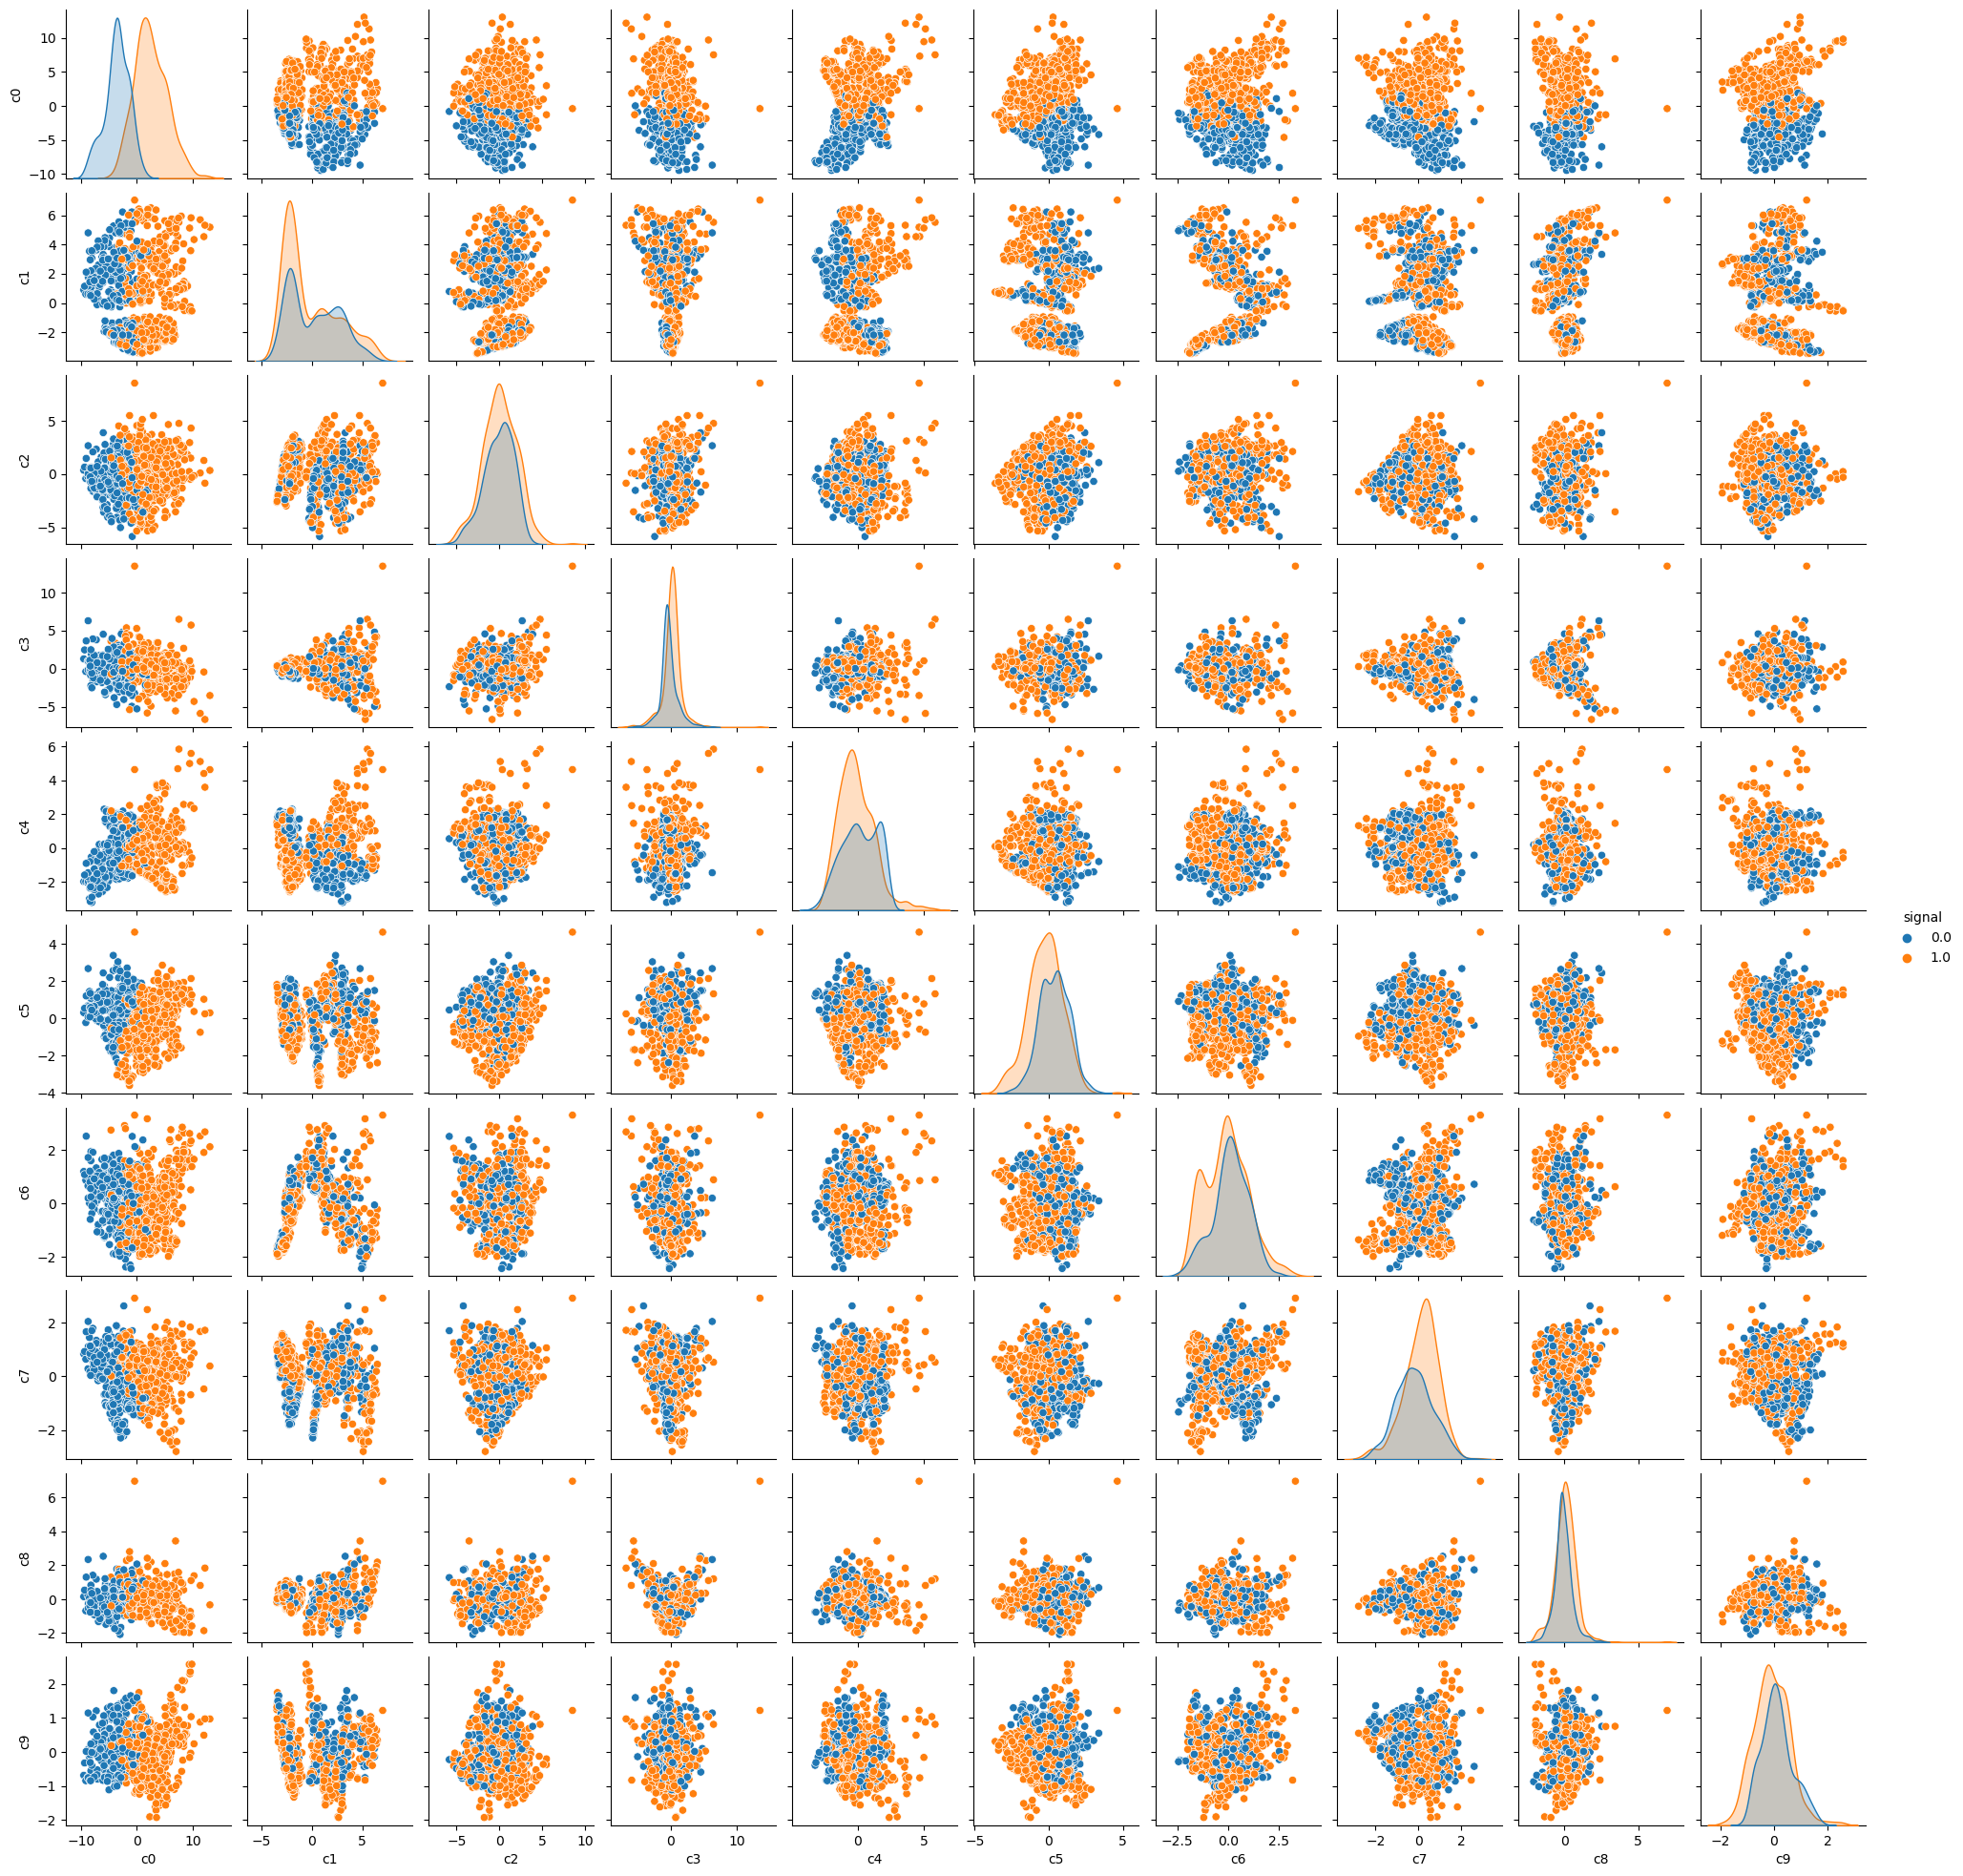

In [40]:
plotdims = 10
plot_each_rows = 1
svd_dfplot = svd_df[compressed_df_cols].iloc[:,:plotdims]
svd_dfplot['signal']=y_train
ax = sns.pairplot(svd_dfplot.iloc[::plot_each_rows,:], hue='signal', height=2)

Comparing Eigen0 with the other Eigen components... there's an obvious segregation of the different signals. datapoints from the same type of signal tend to cluster together

Hard to get the full analysis of the differences and similarities between data points while comparing these eigenvalues, manual interpretation from viewer's mind is needed to understand the relation.

In [41]:
def scatter_3D(A, elevation=30, azimuth=120):
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [42]:
svd_df['signal'] = y_train
interactive(scatter_3D, A=fixed(svd_df), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

### T-SNE Visualization

In [46]:
eta = TSNE(n_components=2)
tsne = eta.fit_transform(svd_df[compressed_df_cols])
tsne_df = pd.DataFrame(tsne, columns=['x','y'], index=svd_df.index)

c:\Users\antho\anaconda3\envs\mytfenv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\antho\anaconda3\envs\mytfenv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [52]:
tsne_df['signal'] = y_train

C:\Users\antho\AppData\Local\Temp\ipykernel_19612\1595749647.py:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot:xlabel='x', ylabel='y'>

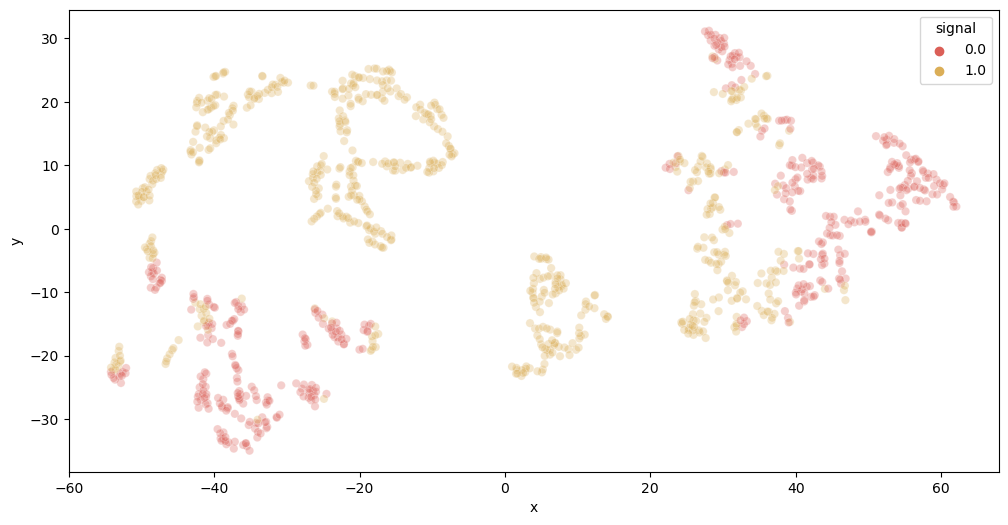

In [63]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    x="x", y="y",
    hue="signal",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.3)

Another segregation minus the apparent overlaps of the yellow/orange signals in the middle. Though, they can be distinguished quite well with 10 Eigenvalues compared to 37 original feats

### Test model with and without Dimensionality Reduction to see any improvement on accuracy and training time

In [64]:
import time
start_time = time.time()

scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [66]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('SVC', SVC()))
models.append(('NB', GaussianNB())) 

In [67]:
num_folds = 10
SEED = 43

In [68]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.589117 (0.034323)
KNN: 0.568964 (0.065313)
CART: 0.977170 (0.007030)
LDA: 0.960472 (0.016367)
NN: 0.547011 (0.083125)
AB: 0.978932 (0.011894)
GBM: 0.986819 (0.008125)
RF: 0.979786 (0.011213)
ETC: 0.971891 (0.014615)
SVC: 0.589117 (0.034323)
NB: 0.565463 (0.037324)


In [74]:
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80, n_jobs=-1)
cv_results_XTrain= cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
print("Time Without Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time Without Dimensionality Reduction--- 4.015160322189331 seconds ---


In [75]:
start_time = time.time()
X_SVD= svd_df[compressed_df_cols].iloc[:,:10]
cv_results_SVD = cross_val_score(model, X_SVD, y_train, cv=kfold, scoring=scoring)
print("Time with Dimensionality Reduction--- %s seconds ---" % (time.time() - start_time))

Time with Dimensionality Reduction--- 0.835761308670044 seconds ---


In [76]:
print("Result without Dimensionality Reduction: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Result with Dimensionality Reduction: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Result without Dimensionality Reduction: 0.980671 (0.014070)
Result with Dimensionality Reduction: 0.961341 (0.025561)


Although the model performed better without the Dimensionality reduction... at the cost of a longer training time.

WITH the dimensionality reduction, it almost achieved the same accuracy as without the DR... and improved on cutting training time by 20 fold! another poggies